In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline


In [3]:
CLIENTS_PATH = 'data.csv'
TARGET = 'Credit Default'

TREATMENT_NAME = 'treatment'
TARGET_NAME = 'target'

SELECTED_FEATURE_NAMES= ['recency', 
                         'history',
                         'used_discount',
                         'used_bogo',
                         #'zip_code',           # класс местности Пригородный/Городской/Сельский
                         'zip_code__cat',
                         'is_referral',
                         #'channel'             # канал который использует покупатель Телефон/Интернет/Многоканальный
                         'channel__cat'
                        ]

cat_features = ['used_discount',    # использование дискаунта раньше
                'used_bogo',        # использовал ли покупку раньше
                'zip_code__cat',         # класс местности Пригородный/Городской/Сельский
                'is_referral',      # был ли клиент приобретен через реферальный канал
                'channel__cat'           # канал который использует покупатель Телефон/Интернет/Многоканальный
]

In [4]:
# загрузка набора данных маркетинговых кампаний
df_clients = pd.read_csv(CLIENTS_PATH)

In [5]:
# переименовать поля
df_clients = df_clients.rename(columns={
    'offer':TREATMENT_NAME, 
    'conversion':TARGET_NAME})

In [6]:
# приводим поле treatment к бинарному виду
df_clients[TREATMENT_NAME] = df_clients[TREATMENT_NAME].map({'No Offer':False}).astype(bool)


In [7]:
# настройка категориальных признаков если такие имеются
df_clients['zip_code__cat'] = df_clients['zip_code'].map({
    'Surburban':1, 
    'Urban':2, 
    'Rural':3
    }).astype(int)
df_clients['channel__cat'] = df_clients['channel'].map({
    'Web':1, 
    'Phone':2, 
    'Multichannel':3
    }).astype(int)

In [8]:
# сделать разбиение набора данных на тренировочную и тестовую выборки
X = df_clients[SELECTED_FEATURE_NAMES]      # признаки о клиенте
y = df_clients[TARGET_NAME]                 # целевой признак
treat = df_clients[TREATMENT_NAME]          # те на кого была произведена маркетинговая кампания 

X_train, X_valid, y_train, y_valid, treat_train, treat_valid = train_test_split(X, y, treat, test_size=0.30, random_state=21)

In [16]:
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@30%': []
}

# сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)


In [10]:
from sklearn.utils.validation import check_consistent_length

In [11]:
# провести uplift-моделирование 3 способами: 
# одна модель с признаком коммуникации (S learner), 
# модель с трансформацией таргета (трансформация классов п. 2. 1) 
# вариант с двумя независимыми моделями

## Uplift-моделирование S learner

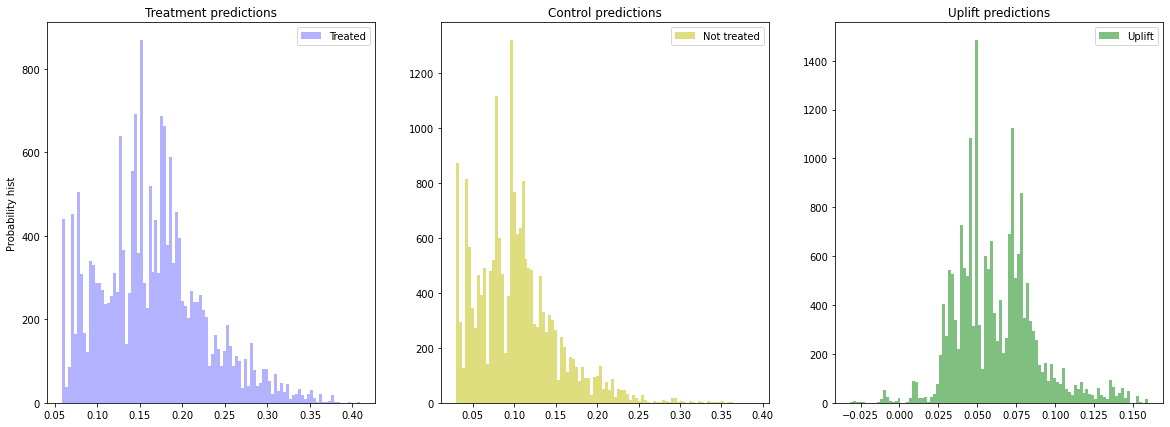

In [18]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# воспользуемся catboost
from catboost import CatBoostClassifier

N =20000
sm = SoloModel(  CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(  X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_valid)
sm_score = uplift_at_k( y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(   sm.trmnt_preds_ , sm.ctrl_preds_, bins=100);

In [19]:
# топ признаки
pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,treatment,21.907619
1,is_referral,20.888463
2,used_bogo,12.325199
3,zip_code__cat,11.518851
4,recency,10.804377
5,used_discount,8.397037
6,history,8.193585
7,channel__cat,5.964868


## Модель с трансформацией таргета